## Compare Ultima & Illumina run

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import scanpy as sc
import rapids_singlecell as rsc
import numpy as np
import pandas as pd

from preprocess import _convert_oak_path

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.autolayout'] = True

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

/home/emmadann/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
PLOTDIR = f'../../results/ultima_vs_illumina/'
sc.settings.figdir = PLOTDIR

def save_plot(pl_name, plot_dir = None):
    if plot_dir is None:
        plot_dir = PLOTDIR
    plt.savefig(f'{plot_dir}/{pl_name}.pdf');
    plt.savefig(f'{plot_dir}/{pl_name}.png');

In [4]:
# Read config
config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)


In [5]:

experiment_names = {'Illumina':'PilotD2Redo_Lane2', 'Ultima':'PilotD2Redo_Lane2_Ultima'}
sgrna_obs = {}
sgrna_var = {}
for k,experiment_name in experiment_names.items():
    all_sgrna_obs = pd.DataFrame()
    all_sgrna_var = pd.DataFrame()
    exp_config = config[experiment_name]
    exp_datadir = _convert_oak_path(exp_config['datadir'])
    exp_sample_metadata_csv = _convert_oak_path(exp_config['sample_metadata'])
    sample_metadata = pd.read_csv(exp_sample_metadata_csv, index_col=0)
    try:
        for s in sample_metadata['library_id'].unique():
            sgrna_ad_obs = sc.read_h5ad(exp_datadir + f'{s}.sgRNA.h5ad', backed=True).obs.copy()
            sgrna_ad_var = sc.read_h5ad(exp_datadir + f'{s}.sgRNA.h5ad', backed=True).var.copy()
            sgrna_ad_var['sample_id'] = s.replace("_Lane2_Ultima", '')
            sgrna_ad_obs.index = sgrna_ad_obs.index.str.replace("_Lane2_Ultima", '')
            all_sgrna_obs = pd.concat([all_sgrna_obs, sgrna_ad_obs])
            all_sgrna_var = pd.concat([all_sgrna_var, sgrna_ad_var])
    except:
        for s in sample_metadata['cell_sample_id'].unique():
            sgrna_ad_obs = sc.read_h5ad(exp_datadir + f'{s}.sgRNA.h5ad', backed=True).obs.copy()
            sgrna_ad_var = sc.read_h5ad(exp_datadir + f'{s}.sgRNA.h5ad', backed=True).var.copy()
            sgrna_ad_var['sample_id'] = s
            all_sgrna_obs = pd.concat([all_sgrna_obs, sgrna_ad_obs])
            all_sgrna_var = pd.concat([all_sgrna_var, sgrna_ad_var])
    all_sgrna_obs['sequencing_tech'] = k
    all_sgrna_var['sequencing_tech'] = k
    sgrna_var[k] = all_sgrna_var
    sgrna_obs[k] = all_sgrna_obs

all_df = pd.concat([sgrna_obs['Ultima'], sgrna_obs['Illumina']])

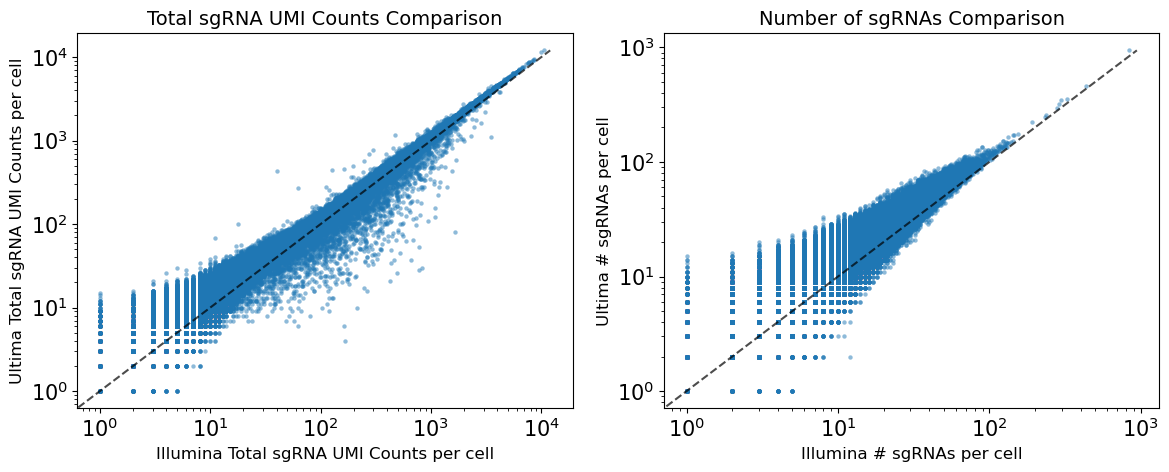

In [6]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot - Total sgRNA UMI Counts
compare_df_counts = all_df[['sequencing_tech', 'total_counts']].pivot(columns='sequencing_tech', values='total_counts')
compare_df_counts['sample_id'] = compare_df_counts.index.str.split('_').str[1:].str.join("_")

sns.scatterplot(data=compare_df_counts, x='Illumina', y='Ultima', s=10, linewidth=0, alpha=0.5, ax=axes[0]);
axes[0].set_xscale('log'); axes[0].set_yscale('log');
# Add diagonal line
max_val = max(compare_df_counts['Illumina'].max(), compare_df_counts['Ultima'].max())
min_val = min(compare_df_counts['Illumina'].min(), compare_df_counts['Ultima'].min())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7);
axes[0].set_xlabel('Illumina Total sgRNA UMI Counts per cell', fontsize=12);
axes[0].set_ylabel('Ultima Total sgRNA UMI Counts per cell', fontsize=12);
axes[0].set_title('Total sgRNA UMI Counts Comparison', fontsize=14)

# Second subplot - Number of sgRNAs
compare_df_genes = all_df[['sequencing_tech', 'n_genes_by_counts']].pivot(columns='sequencing_tech', values='n_genes_by_counts')
compare_df_genes['sample_id'] = compare_df_genes.index.str.split('_').str[1:].str.join("_")

sns.scatterplot(data=compare_df_genes, x='Illumina', y='Ultima', s=10, linewidth=0, alpha=0.5, ax=axes[1]);
axes[1].set_xscale('log'); axes[1].set_yscale('log');
# Add diagonal line
max_val = max(compare_df_genes['Illumina'].max(), compare_df_genes['Ultima'].max())
min_val = min(compare_df_genes['Illumina'].min(), compare_df_genes['Ultima'].min())
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7);
axes[1].set_xlabel('Illumina # sgRNAs per cell', fontsize=12);
axes[1].set_ylabel('Ultima # sgRNAs per cell', fontsize=12);
axes[1].set_title('Number of sgRNAs Comparison', fontsize=14)

plt.tight_layout()

In [7]:
all_df = pd.concat([sgrna_var['Ultima'], sgrna_var['Illumina']])
compare_df_counts = all_df.pivot(index=['sgrna_id','sample_id'], columns='sequencing_tech', values='total_counts').reset_index()
compare_df_counts[compare_df_counts['sgrna_id'].str.startswith("GNG7")]

sequencing_tech sgrna_id               sample_id  Illumina   Ultima
33296             GNG7-1        PilotD2Redo_Day7   12517.0  14314.0
33297             GNG7-1        PilotD2Redo_Rest    6369.0   7323.0
33298             GNG7-1  PilotD2Redo_Restim24hr    7202.0   7104.0
33299             GNG7-1   PilotD2Redo_Restim6hr    6329.0   7205.0
33300             GNG7-2        PilotD2Redo_Day7     642.0    729.0
33301             GNG7-2        PilotD2Redo_Rest    1469.0   1687.0
33302             GNG7-2  PilotD2Redo_Restim24hr     106.0    133.0
33303             GNG7-2   PilotD2Redo_Restim6hr     999.0   1141.0

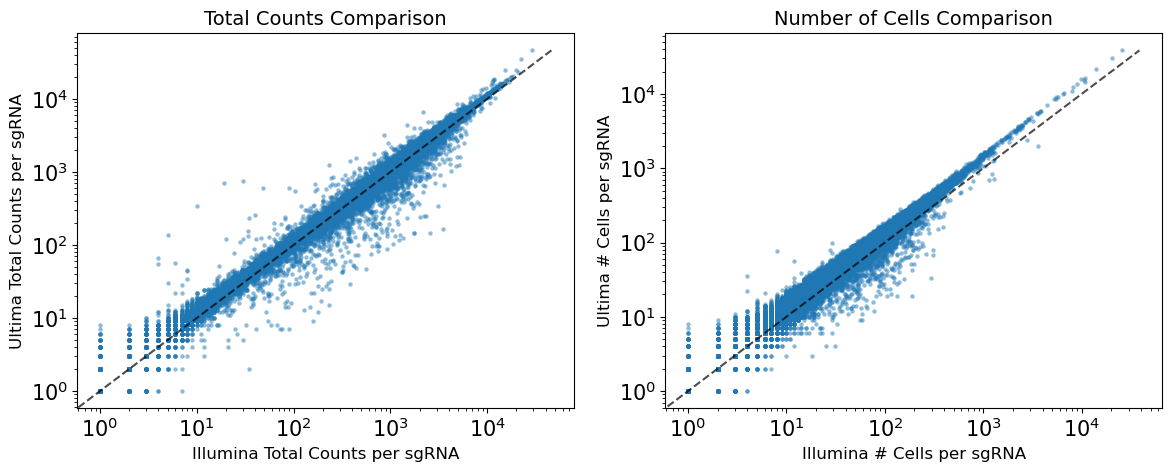

In [53]:
all_df = pd.concat([sgrna_var['Ultima'], sgrna_var['Illumina']])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for total_counts
compare_df_counts = all_df.pivot(index=['sgrna_id','sample_id'], columns='sequencing_tech', values='total_counts').reset_index()
sns.scatterplot(data=compare_df_counts, x='Illumina', y='Ultima', s=10, linewidth=0, alpha=0.5, ax=axes[0]);
axes[0].set_xscale('log'); axes[0].set_yscale('log');
# Add diagonal line
max_val = max(compare_df_counts['Illumina'].max(), compare_df_counts['Ultima'].max())
min_val = min(compare_df_counts['Illumina'].min(), compare_df_counts['Ultima'].min())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7);
axes[0].set_xlabel('Illumina Total Counts per sgRNA', fontsize=12);
axes[0].set_ylabel('Ultima Total Counts per sgRNA', fontsize=12);
axes[0].set_title('Total Counts Comparison', fontsize=14)

# Plot for n_cells
compare_df_cells = all_df.pivot(index=['sgrna_id','sample_id'], columns='sequencing_tech', values='n_cells').reset_index()
sns.scatterplot(data=compare_df_cells, x='Illumina', y='Ultima', s=10, linewidth=0, alpha=0.5, ax=axes[1]);
axes[1].set_xscale('log'); axes[1].set_yscale('log');
# Add diagonal line
max_val = max(compare_df_cells['Illumina'].max(), compare_df_cells['Ultima'].max())
min_val = min(compare_df_cells['Illumina'].min(), compare_df_cells['Ultima'].min())
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7);
axes[1].set_xlabel('Illumina # Cells per sgRNA', fontsize=12);
axes[1].set_ylabel('Ultima # Cells per sgRNA', fontsize=12);
axes[1].set_title('Number of Cells Comparison', fontsize=14)

plt.tight_layout()

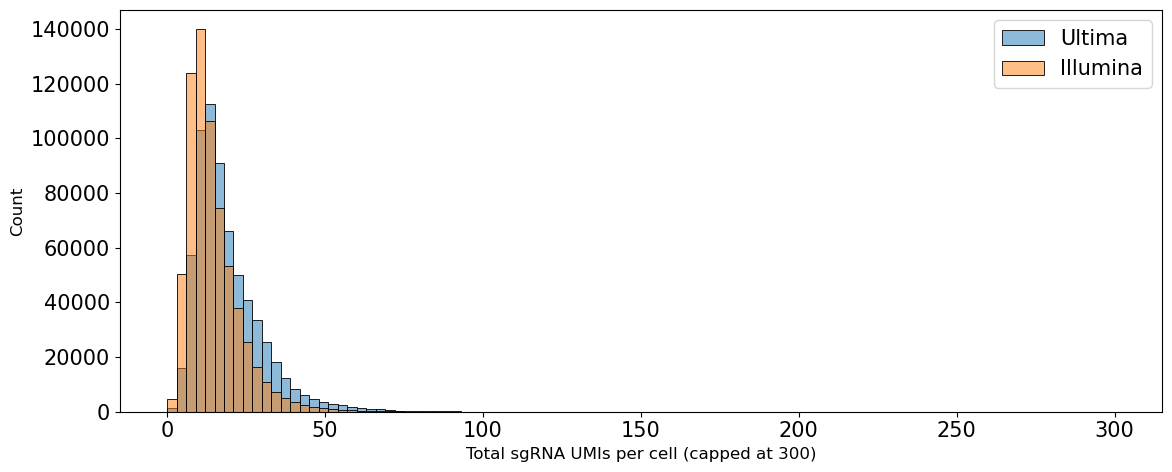

In [54]:
# Create a single figure for comparison
fig, ax = plt.subplots(figsize=(12, 5))

# Cap values at 300 for both datasets
ultima_data = sgrna_obs['Ultima'].copy()
illumina_data = sgrna_obs['Illumina'].copy()
ultima_data['n_genes_by_counts'] = ultima_data['n_genes_by_counts'].clip(upper=300)
illumina_data['n_genes_by_counts'] = illumina_data['n_genes_by_counts'].clip(upper=300)

# Plot histogram for both Ultima and Illumina data on the same plot
sns.histplot(data=ultima_data, x='n_genes_by_counts', 
             bins=100, alpha=0.5, label='Ultima', ax=ax);
sns.histplot(data=illumina_data, x='n_genes_by_counts', 
             bins=100, alpha=0.5, label='Illumina', ax=ax);

ax.set_xlabel('Total sgRNA UMIs per cell (capped at 300)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.legend()

plt.tight_layout()

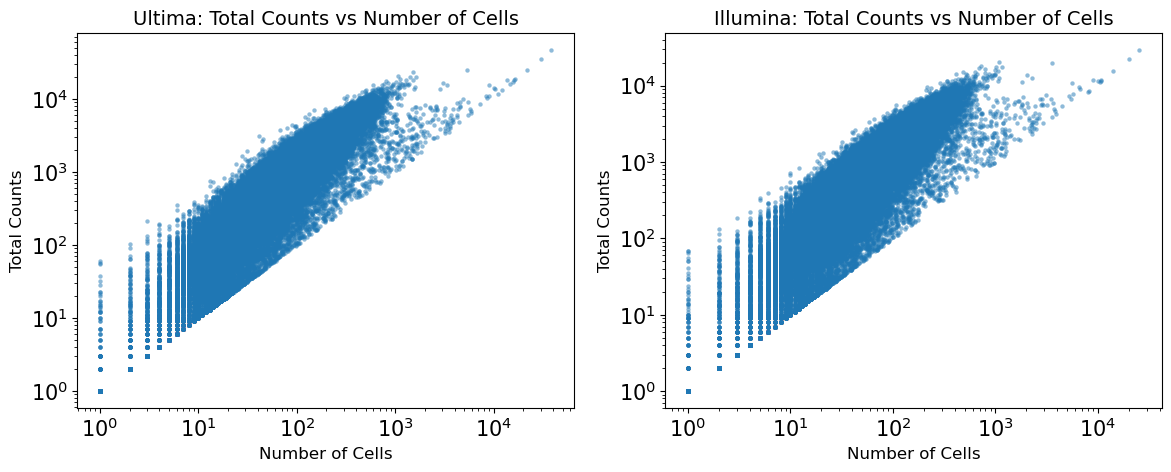

In [55]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Ultima data
sns.scatterplot(data=sgrna_var['Ultima'], x='n_cells', y='total_counts', 
                s=10, linewidth=0, alpha=0.5, ax=axes[0]);
axes[0].set_xscale('log'); axes[0].set_yscale('log');
axes[0].set_xlabel('Number of Cells', fontsize=12);
axes[0].set_ylabel('Total Counts', fontsize=12);
axes[0].set_title('Ultima: Total Counts vs Number of Cells', fontsize=14)

# Plot for Illumina data
sns.scatterplot(data=sgrna_var['Illumina'], x='n_cells', y='total_counts', 
                s=10, linewidth=0, alpha=0.5, ax=axes[1]);
axes[1].set_xscale('log'); axes[1].set_yscale('log');
axes[1].set_xlabel('Number of Cells', fontsize=12);
axes[1].set_ylabel('Total Counts', fontsize=12);
axes[1].set_title('Illumina: Total Counts vs Number of Cells', fontsize=14)

plt.tight_layout()

In [8]:
# Read config
config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)


experiment_names = {'Illumina':'PilotD2Redo_Lane2', 'Ultima':'PilotD2Redo_Lane2_Ultima'}
all_sgrna_assignment = pd.DataFrame()
for k,experiment_name in experiment_names.items():
    exp_config = config[experiment_name]
    exp_datadir = _convert_oak_path(exp_config['datadir'])
    sgrna_assignment = pd.read_csv(f'{exp_datadir}/sgrna_assignment.csv', index_col=0)
    sgrna_assignment.index = sgrna_assignment.index.str.replace("_Lane2_Ultima", '')
    sgrna_assignment['tech'] = k
    all_sgrna_assignment = pd.concat([all_sgrna_assignment, sgrna_assignment])

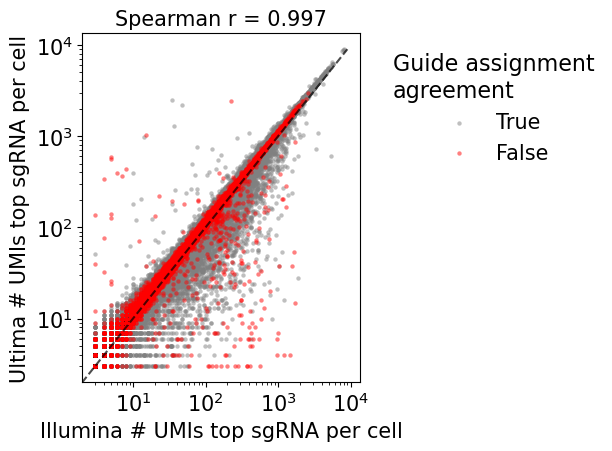

In [13]:
compare_df = all_sgrna_assignment.pivot(columns='tech', values='top_guide_umi_counts')

agreement_compare_df = all_sgrna_assignment.pivot(columns='tech', values='guide_id').fillna('no_guide')
compare_df['agreement'] = agreement_compare_df['Ultima'] == agreement_compare_df['Illumina']
# Calculate correlation coefficient
corr = compare_df['Illumina'].corr(compare_df['Ultima'], method='spearman')
# Create separate dataframes for agreement and disagreement
disagreement_df = compare_df[~compare_df['agreement']]
agreement_df = compare_df[compare_df['agreement']]
# Plot disagreement points first (False on top)
plt.figure(figsize=(6.4, 4.8))
sns.scatterplot(data=agreement_df, x='Illumina', y='Ultima', 
                color='grey', s=10, linewidth=0, alpha=0.5, label='True');
sns.scatterplot(data=disagreement_df, x='Illumina', y='Ultima', 
                color='red', s=10, linewidth=0, alpha=0.5, label='False');
plt.xscale('log');plt.yscale('log');
# Add diagonal line
max_val = max(compare_df['Illumina'].max(), compare_df['Ultima'].max())
min_val = min(compare_df['Illumina'].min(), compare_df['Ultima'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7);
plt.xlabel('Illumina # UMIs top sgRNA per cell', fontsize=15);
plt.ylabel('Ultima # UMIs top sgRNA per cell', fontsize=15);
plt.title(f'Spearman r = {corr:.3f}', fontsize=15);
# Move legend outside of plot
plt.legend(title='Guide assignment\nagreement', loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False);

In [107]:
import matplotlib

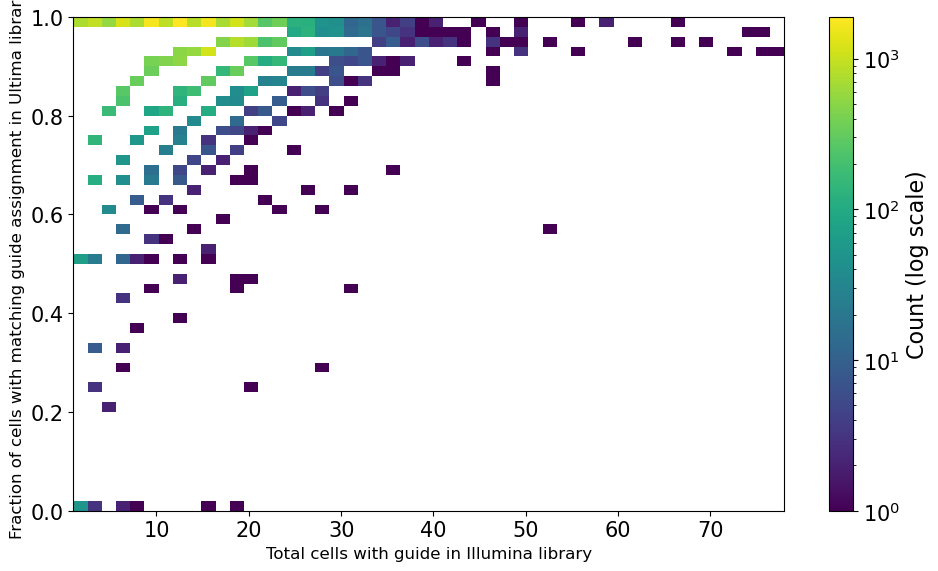

In [177]:
compare_df = all_sgrna_assignment.pivot(columns='tech', values='guide_id')
compare_df = compare_df.fillna('no_guide')
compare_df['agreement'] = compare_df['Ultima'] == compare_df['Illumina']

# Get counts for each guide RNA
counts_all = compare_df['Illumina'].value_counts()
counts_agreements = compare_df[compare_df['agreement']]['Ultima'].value_counts()

# Create a dataframe for plotting
guide_counts_df = pd.DataFrame({
    'total_cells': counts_all,
    'agreement_cells': counts_agreements
}).fillna(0)
guide_counts_df['frac_agreement'] = guide_counts_df['agreement_cells']/guide_counts_df['total_cells']
guide_counts_df = guide_counts_df.drop(['multi_sgRNA', 'no_guide'])

# Plot total counts vs agreement counts for each guide RNA as a 2D histogram
plt.figure(figsize=(10, 6))
h = plt.hist2d(guide_counts_df['total_cells'], guide_counts_df['frac_agreement'], 
              bins=50, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar(h[3], label='Count (log scale)')
# plt.xscale('log')
# plt.yscale('log')

# # Add diagonal line representing perfect agreement
# max_val = max(guide_counts_df['total_cells'].max(), guide_counts_df['frac_agreement'].max())
# min_val = max(1, min(guide_counts_df['total_cells'].min(), guide_counts_df['frac_agreement'].min()))
# plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7)

plt.xlabel('Total cells with guide in Illumina library', fontsize=12)
plt.ylabel('Fraction of cells with matching guide assignment in Ultima library', fontsize=12)
# plt.title('# cells with guide in agreement', fontsize=14)
plt.tight_layout()

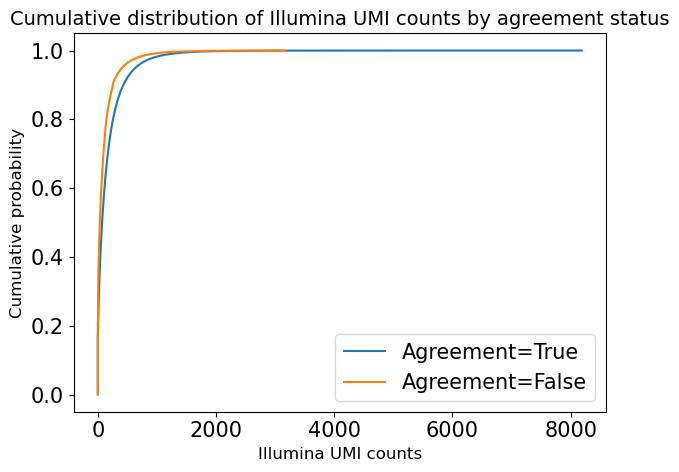

In [187]:
compare_df = all_sgrna_assignment.pivot(columns='tech', values='guide_id')
compare_df = compare_df.fillna('no_guide')
compare_df['agreement'] = compare_df['Ultima'] == compare_df['Illumina']

# Get UMI counts for both technologies
compare_df['umi_counts_Illumina'] = all_sgrna_assignment.pivot(columns='tech', values='top_guide_umi_counts')['Illumina']
compare_df['umi_counts_Ultima'] = all_sgrna_assignment.pivot(columns='tech', values='top_guide_umi_counts')['Ultima']

# Plot distribution of UMI counts for agreement=True and agreement=False
plt.figure(figsize=(12, 5))

# Plot Illumina UMI counts
plt.subplot(1, 2, 1)
# Get data for histograms
agree_data = compare_df[compare_df['agreement']]['umi_counts_Illumina'].dropna()
disagree_data = compare_df[~compare_df['agreement']]['umi_counts_Illumina'].dropna()
# Create cumulative distribution plots
sorted_agree = np.sort(agree_data)
sorted_disagree = np.sort(disagree_data)
cumulative_agree = np.arange(1, len(sorted_agree) + 1) / len(sorted_agree)
cumulative_disagree = np.arange(1, len(sorted_disagree) + 1) / len(sorted_disagree)
plt.plot(sorted_agree, cumulative_agree, label='Agreement=True')
plt.plot(sorted_disagree, cumulative_disagree, label='Agreement=False')
plt.xlabel('Illumina UMI counts', fontsize=12)
plt.ylabel('Cumulative probability', fontsize=12)
plt.title('Cumulative distribution of Illumina UMI counts by agreement status', fontsize=14)
plt.legend()


tech                                                  Illumina       Ultima  \
AAACAAGCAAACAATCAACGCCGA-1_PilotD2Redo_Restim24hr      TM2D2-1      TM2D2-1   
AAACAAGCAAACAATCAACGGGAA-1_PilotD2Redo_Day7        multi_sgRNA  multi_sgRNA   
AAACAAGCAAACAATCACAGACCT-1_PilotD2Redo_Rest            CBLL1-2      CBLL1-2   
AAACAAGCAAACAATCACTACTCA-1_PilotD2Redo_Restim6hr       SESN1-1      SESN1-1   
AAACAAGCAAACAATCACTTTAGG-1_PilotD2Redo_Day7        multi_sgRNA  multi_sgRNA   
...                                                        ...          ...   
TTTGTGAGTTTGACTAATGTTGAC-1_PilotD2Redo_Day7        multi_sgRNA  multi_sgRNA   
TTTGTGAGTTTGCAACAACGGGAA-1_PilotD2Redo_Day7           PHLDB2-1     PHLDB2-1   
TTTGTGAGTTTGCAACAGTGAGTG-1_PilotD2Redo_Restim6hr   multi_sgRNA  multi_sgRNA   
TTTGTGAGTTTGCAACATCATGTG-1_PilotD2Redo_Restim24hr     no_guide     no_guide   
TTTGTGAGTTTGCAACATGTTGAC-1_PilotD2Redo_Day7        multi_sgRNA  multi_sgRNA   

tech                                               agreement  \
AAACAAGCAAACAATCAACGCCGA-1_PilotD2Redo_Restim24hr       True   
AAACAAGCAAACAATCAACGGGAA-1_PilotD2Redo_Day7             True   
AAACAAGCAAACAATCACAGACCT-1_PilotD2Redo_Rest             True   
AAACAAGCAAACAATCACTACTCA-1_PilotD2Redo_Restim6hr        True   
AAACAAGCAAACAATCACTTTAGG-1_PilotD2Redo_Day7             True   
...                                                      ...   
TTTGTGAGTTTGACTAATGTTGAC-1_PilotD2Redo_Day7             True   
TTTGTGAGTTTGCAACAACGGGAA-1_PilotD2Redo_Day7             True   
TTTGTGAGTTTGCAACAGTGAGTG-1_PilotD2Redo_Restim6hr        True   
TTTGTGAGTTTGCAACATCATGTG-1_PilotD2Redo_Restim24hr       True   
TTTGTGAGTTTGCAACATGTTGAC-1_PilotD2Redo_Day7             True   

tech                                               umi_counts_Illumina  
AAACAAGCAAACAATCAACGCCGA-1_PilotD2Redo_Restim24hr                 67.0  
AAACAAGCAAACAATCAACGGGAA-1_PilotD2Redo_Day7                       70.0  
AAACAAGCAAACAATCACAGACCT-1_PilotD2Redo_Rest                       19.0  
AAACAAGCAAACAATCACTACTCA-1_PilotD2Redo_Restim6hr                   3.0  
AAACAAGCAAACAATCACTTTAGG-1_PilotD2Redo_Day7                     1088.0  
...                                                                ...  
TTTGTGAGTTTGACTAATGTTGAC-1_PilotD2Redo_Day7                      413.0  
TTTGTGAGTTTGCAACAACGGGAA-1_PilotD2Redo_Day7                      135.0  
TTTGTGAGTTTGCAACAGTGAGTG-1_PilotD2Redo_Restim6hr                 134.0  
TTTGTGAGTTTGCAACATCATGTG-1_PilotD2Redo_Restim24hr                  0.0  
TTTGTGAGTTTGCAACATGTTGAC-1_PilotD2Redo_Day7                     1189.0  

[672906 rows x 4 columns]

In [133]:
compare_df = all_sgrna_assignment.pivot(columns='tech', values='guide_id')
compare_df = compare_df.fillna('no_guide')
compare_df['agreement'] = compare_df['Ultima'] == compare_df['Illumina']
disagree_compare_df = compare_df[~compare_df['agreement']]
disagree_compare_df['Illumina'] = np.where(disagree_compare_df['Illumina'].isin(['no_guide', 'multi_sgRNA']), disagree_compare_df['Illumina'], 'single_guide')
disagree_compare_df['Ultima'] = np.where(disagree_compare_df['Ultima'].isin(['no_guide', 'multi_sgRNA']), disagree_compare_df['Ultima'], 'single_guide')

df = disagree_compare_df.value_counts().reset_index()
df

Illumina        Ultima  agreement  count
0  single_guide   multi_sgRNA      False   9287
1      no_guide  single_guide      False   7743
2  single_guide      no_guide      False   6507
3   multi_sgRNA      no_guide      False   2540
4   multi_sgRNA  single_guide      False   2013
5      no_guide   multi_sgRNA      False   1269
6  single_guide  single_guide      False     83

In [137]:
import plotly.graph_objects as go

# Replace empty strings with "unknown"
df["Illumina"] = df["Illumina"].replace("", "unknown")


# Get unique values and create indices
illumina_categories = df["Illumina"].unique().tolist()
ultima_categories = df["Ultima"].unique().tolist()

# Calculate total values for each category
illumina_totals = df.groupby("Illumina")["count"].sum().to_dict()
ultima_totals = df.groupby("Ultima")["count"].sum().to_dict()

# Create node labels with totals - source nodes first, then target nodes
labels = [f"{cat} ({illumina_totals.get(cat, 0):,})" for cat in illumina_categories] + \
         [f"{cat} ({ultima_totals.get(cat, 0):,})" for cat in ultima_categories]

# Create a mapping of source and target names to node indices
source_indices = {source: i for i, source in enumerate(illumina_categories)}
target_indices = {target: i + len(illumina_categories) for i, target in enumerate(ultima_categories)}

# Create the source, target, and value arrays for the Sankey diagram
sources = [source_indices[row["Illumina"]] for _, row in df.iterrows()]
targets = [target_indices[row["Ultima"]] for _, row in df.iterrows()]
values = df["count"].tolist()

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=["rgba(31, 119, 180, 0.8)"] * len(illumina_categories) + 
              ["rgba(255, 127, 14, 0.8)"] * len(ultima_categories)
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=["rgba(0, 0, 255, 0.2)"] * len(sources)  # Semi-transparent blue
    )
)])

# Update layout
fig.update_layout(
    title_text="Illumina to Ultima Category Flow",
    font_size=12,
    width=700,
    height=500
)

# Show the plot
fig.show()

In [167]:
compare_df[(compare_df['Ultima'] == 'no_guide') & ~compare_df.agreement].value_counts()[0:30]

Illumina     Ultima    agreement
multi_sgRNA  no_guide  False        2540
RFX5-1       no_guide  False          20
ELOF1-2      no_guide  False          19
PIK3AP1-2    no_guide  False          17
TNFAIP8L2-2  no_guide  False          15
GNG7-1       no_guide  False          12
PLLP-1       no_guide  False          11
FUT11-1      no_guide  False          10
KANK1-1      no_guide  False           9
PSD-2        no_guide  False           9
VAMP3-1      no_guide  False           9
MXRA7-2      no_guide  False           8
TMEM94-2     no_guide  False           8
FAM3A-2      no_guide  False           7
KAT2A-2      no_guide  False           7
MUC3A-2      no_guide  False           7
GNB5-1       no_guide  False           7
TMC5-1       no_guide  False           6
NDRG3-1      no_guide  False           6
NT5DC3-2     no_guide  False           6
VKORC1L1-2   no_guide  False           6
MAFK-2       no_guide  False           5
ZNF653-2     no_guide  False           5
RNPEP-1      no_guide  F

In [170]:
guide_counts_df[guide_counts_df['frac_agreement'] < 0.7].sort_values('total_cells', ascending=False)[0:20]

total_cells  agreement_cells  frac_agreement
RFX5-1               52             30.0        0.576923
KANK1-1              35             24.0        0.685714
PSD-2                31             20.0        0.645161
PIK3AP1-2            31             14.0        0.451613
ELOF1-2              28              8.0        0.285714
FUT11-1              28             17.0        0.607143
TMEM94-2             26             17.0        0.653846
UCKL1-2              23             14.0        0.608696
FAM3A-2              22             14.0        0.636364
KAT2A-2              21             14.0        0.666667
VKORC1L1-2           21             10.0        0.476190
PLLP-1               20              5.0        0.250000
VAMP3-1              19              9.0        0.473684
GNB5-1               18              8.0        0.444444
GNG7-1               18              0.0        0.000000
KDM3A-2              18             12.0        0.666667
PORCN-2              17             10.0        0.588235
TSPAN31-1            16             11.0        0.687500
DOCK11-2             16              8.0        0.500000
SPATA13-2            16             11.0        0.687500

## Integration

In [6]:
experiment_names = {'Illumina':'PilotD2Redo_Lane2', 'Ultima':'PilotD2Redo_Lane2_Ultima'}

name = experiment_names['Illumina']
exp_config = config[name]
exp_datadir = _convert_oak_path(exp_config['datadir'])
adata_illumina = sc.read_h5ad(exp_datadir + f'{name}_merged.gex.lognorm.postQC.h5ad')

name = experiment_names['Ultima']
exp_config = config[name]
exp_datadir = _convert_oak_path(exp_config['datadir'])
adata_ultima = sc.read_h5ad(exp_datadir + f'{name}_merged.gex.lognorm.postQC.h5ad')

In [9]:
sc.pp.sample(adata_ultima, fraction=0.1)

In [7]:
sc.pp.sample(adata_illumina, fraction=0.1)

In [15]:
# Concatenate the Illumina and Ultima datasets
adata_combined = adata_illumina.concatenate(adata_ultima, batch_key='tech')
rsc.get.anndata_to_GPU(adata_combined)
rsc.pp.highly_variable_genes(adata_combined)
rsc.tl.pca(adata_combined, svd_solver='arpack')

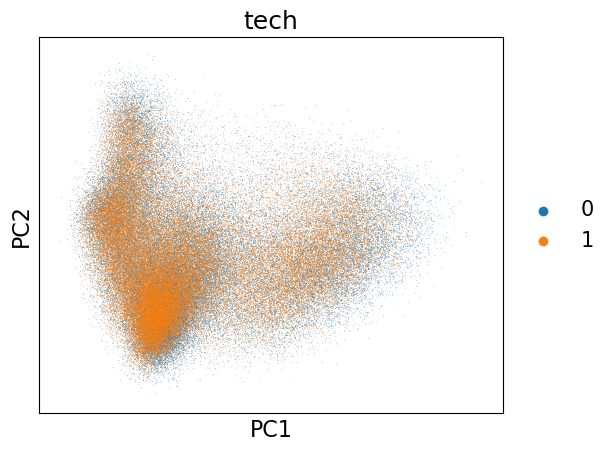

In [17]:
sc.pl.pca(adata_combined, color='tech')

In [19]:
rsc.pp.neighbors(adata_combined, n_neighbors=50)
rsc.tl.umap(adata_combined)

In [47]:
adata_combined.obs['Sequencing tech'] = np.where(adata_combined.obs['tech'] == '1', 'Ultima', "Illumina")
adata_combined.obsm['PCA-UMAP'] = adata_combined.obsm['X_umap'].copy()

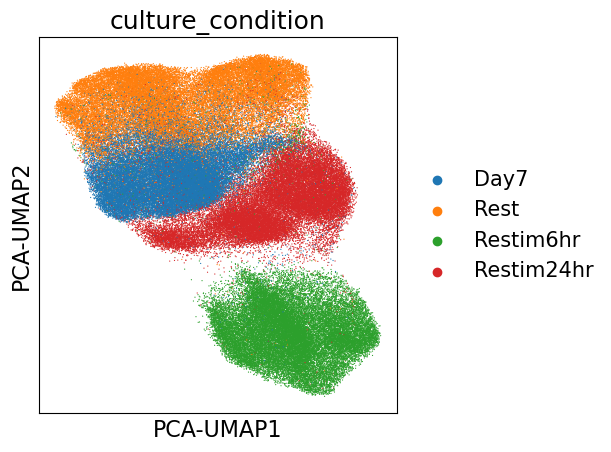

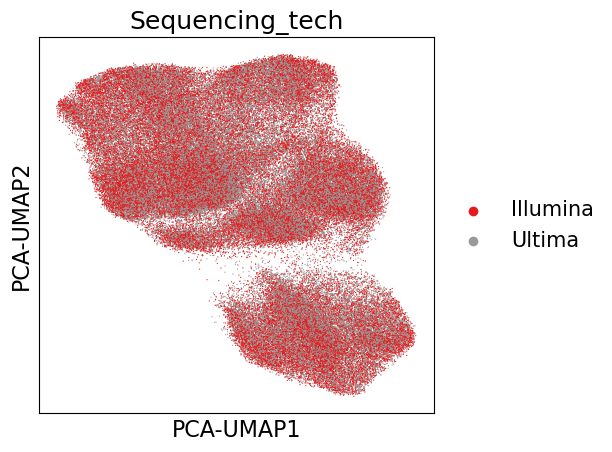

In [48]:
np.random.seed(0)
random_indices = np.random.permutation(list(range(adata_combined.shape[0])))
sc.pl.embedding(adata_combined[random_indices, :], basis='PCA-UMAP',  color='culture_condition', size=3)
sc.pl.embedding(adata_combined[random_indices, :], basis='PCA-UMAP', color='Sequencing_tech', palette='Set1', size=3)

adata_combined